# ST463 - Stochastic Simulation, Training and Calibration

## Stock trading with Reinforcement Learning

Usually, when people think about applying ML to the stock market:  
(a) They think about predicting the value of a stock;  
(b) Or even just the direction (will it go up/down?). Reinforcement Learning can account for both predictions and actions (buy/sell/hold), in the sense that the agent takes *automatically* actions which *should* maximize rewards.

The `.csv` file contains the prices of three stocks: Apple (AAPL), Motorola (MSI), and Starbucks (SBUX). In the exercise, divide data in training and test data, and normalize them.

The assumption of your Reinforcement Learning model are the following:  

1.   **State** will consist of three parts:  
    *   how many shares of each stock You own.  
    *   current price of each stock.  
    *   how much cash you have (uninvested).  

What is the dimension of your state $S_t$?  

2.   **Actions.** For any stock, you can buy, sell, or hold (do nothing). More precisely, you should define the following **actions**:  
    *   If you *sell*, you will sell all shares of that stock that you own.  
    *   If you *buy*, you will buy **as many as possible** $\rightarrow$ **round robin** fashion: Loop through every stock, and buy 1 share until we run out of money.  
    *   If you *hold*, do nothing.  

Besides, use the following convention: sell before buy (in order to raise money). **One** “action” in your model will involve performing all of these steps at once.

3.  **Reward.** Given $ω_t$ vector of shares, $p_t$ vector of prices, and $c_t$ cash at time $t$, the value of the portfoplio is given by $\pi_t = \omega_t^{T} p_t + c_t$. Define the **reward** at time $t+1$ as the variation of the portfolio value $r_{t+1}=\pi_{t+1}-\pi_{t}$.

How to model $Q(s,a)$? You model $Q$ as a linear regression (linear ANN):
\begin{equation*}
    Q(s,:) = W s + b,
\end{equation*}
and you *learn* the linear map from the state $s$ to the $Q$-vector $Q(s,:)$ by the *training* of $W$ and $b$. How?

*   **Define** a *loss function* to minimize the MSE:  
    \begin{equation*}
        J = (r + γ \max_{a^{'}} Q(s^{'}, a^{'})-Q(s, a))^2.
    \end{equation*}
*   **Apply** the *gradient descent method* for training:  
    \begin{equation*}
       W_a = W_a - η \frac{\partial J}{\partial W_a},\quad\quad b_a = b_a - η \frac{\partial J}{\partial b_a},
    \end{equation*}   
where $\eta$ is an hyperparameter representing the learning rate. Instead of plain vanilla gradient descent, you can **speed-up** the training with *momentum*. More precisely, given the set of parameters (weights of linear regression), $w=\{W,b\}$, and the gradient $g(t)=\frac{\partial J}{\partial w}$ at the iteration step $t$, the training with the gradient descent method with momentum is $w(t)=w(t-1)+\nu(t)$. The gradient term improved with momentum is
\begin{equation*}
    \nu(t)=\mu\nu(t-1)-\eta g(t)
\end{equation*}   
with
\begin{equation*}
\begin{cases}
    \mu = \text{momentum term} (0.9, 0.99, etc.).\\
    η = \text{learning rate}.
\end{cases}
\end{equation*}   

**Practical Implementation**
1.   Using linear regression to approximate $Q(s,a)$.
    *   Only the state is input, one output for each action.
    *   Target is a scalar while you have $27$ outputs (all possible actions).


2.   **Prediction** task, i.e. use $Q(s,:)$ at time $t$ to decide the action
    *   Given the weights from the previous step, it is:
    \begin{equation*}
        Q(s,:)=W_{t-1}s + b_{t-1}.
    \end{equation*}
    *   The action (for the *greedy* strategy) is
    \begin{equation*}
        a=\text{argmax}_{a} Q(s,a)
    \end{equation*}
3. **Control** (or **target**) task, i.e. improving the *policy* $a$
    * Update only the weights corresponding to the involved action, that is:
    \begin{equation*}
        w^{a}=w^{a}(t-1) + \mu \nu^{a}(t-1) - \eta g^{a}(t).
    \end{equation*}

In this exercise you have to implement and discuss the previous RL algorithm and plot the distribution of the final portfolio value both in-sample and out-of-sample.

You should compare and discuss your result with the buy-and-hold portfolio or other standard portfolio strategies (e.g. random trading, i.e. pure epsilon-strategy, or Markowitz portfolio for the three stocks AAPL, MSI, SBUX).

# Proposition of solution

To tackle this problem, we have a dataset composed of 3 stocks prices: AAPL,MSI,SBUX. The goal is to come up with an efficient trading strategy using a **reinforcement learning model**. To discuss how efficient this model really is, we will compare it to 2 others baselines strategies:  
* **Buy and hold:**  The buy-and-hold strategy allocates the initial cash equally among the available stocks by purchasing shares at the start and holding them throughout the entire trading period. No further trading occurs after the initial investment. This approach serves as a stable benchmark, reflecting the underlying market trends without active management.
* **Random strategy:**  The random trading strategy selects agent's actions purely at random at each time step, without considering the market state or portfolio performance. Over multiple episodes, it generates a distribution of portfolio values by averaging random trading behaviors. This strategy acts as a naive baseline to assess whether the Reinforcement Learning model can outperform random decision-making.  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
from copy import deepcopy
import time
import seaborn as sns
sns.set()

# Set random seed for reproducibility
np.random.seed(156872)
random.seed(156872)

I will first explain separatly each part of the reinforcement learning algorithm, my assumptions and where the ideas come from. Then we will train the RL agent, plot some graphs and compare the performance of all the strategies.

## Break down the parts of the RL algo

### Import data

We start by defining a function to load and normalize the data. I choose to not normalize my data between 0 and 1 as we usually do with machine learning algorithms. Instead I normalize the data between 1 and 10, otherwise the training doesn't work. For exemple, the cheapest price would be normalized to 0, but the agent might want to  buy an infinite amount of shares at this price. Similar issue for selling at a price of 0.

In [3]:
def load_and_prepare_data(file_path, train_ratio=0.66,range_min=1, range_max=10):
    """
    Load the stock data, normalize it, and split into training and test sets.
    """
    # Load the data
    df = pd.read_csv(file_path)
    # Split train/test data sets
    train_size = int(len(df) * train_ratio) #get the index corresponding to 75% of the data for training
    train_data = df[:train_size]
    test_data = df[train_size:]
    print(f"Trainset data shape: {train_data.shape}, Testset data shape: {test_data.shape}")
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(range_min, range_max))
    train_data_scaled = pd.DataFrame(
        scaler.fit_transform(train_data),
        columns=train_data.columns
    )
    test_data_scaled = pd.DataFrame(
        scaler.transform(test_data),
        columns=test_data.columns
    )
    return (train_data_scaled, test_data_scaled)


### Trading Environment - First object

The `MyStockTradingEnv` class defined below is here to track and record the progress and metrics of the model over the train and test periods. 
As explained in the subject, the key parameters/functions are:  
* **Action space**: The agent can perform 3^3=27 possible actions (buy/sell/hold for each 3 stocks) at each time step.  
* **State dimension**: It is defined by the numbers of shares owned in each 3 stocks, the 3 stock prices and the cash amount. So the state dimension is 7 in total.
* **Sell first**: As explained above, we have to sell first in order to raise cash.  
* **Round robin fashion**: Buy shares until we run out of money: following the method explained in the subject.
* **Decode action function**: Returns the actual actions :Buy/Hold/Sell for each stock. Useful for the round robin function where we have to know the actions decided by the agent.
* **Step function**: implement the logic of the algorithm.
* **Reward score**: The subject tells us to compute the reward as the variation of the portfolio value. I had issues with stability with this definition so I decided to define the reward as the relative variation of the portfolio and clip the values to +/- 50%.

In [4]:
class MyStockTradingEnv:
    """
    Stock trading environment
    """
    def __init__(self, data, initial_cash=10000):
        self.data = data
        self.initial_cash = initial_cash
        self.num_stocks = 3
        # Define action space: for each stock (buy, sell, hold) -> 3^3 = 27 actions
        self.action_space = 27
        # State dimension: 3 (shares owned) + 3 (stock prices) + 1 (cash) = 7
        self.state_dim = 7
        # Initialize variables
        self.reset()

    def reset(self):
        """Reset the environment to initial state."""
        self.current_step = 0
        self.cash = self.initial_cash
        self.shares = np.zeros(self.num_stocks)  # Format: [AAPL, MSI, SBUX]
        self.done = False
        return (self.get_state())

    def get_state(self):
        """Return normalized current state as vector [shares_owned, current_prices, cash]."""
        prices = self.data.iloc[self.current_step].values
        # Normalize state components
        max_shares = max(np.max(self.shares), 1)
        shares_norm = self.shares / max_shares
        prices_norm = prices / np.max(prices)
        cash_norm = self.cash / self.initial_cash
        return (np.concatenate([shares_norm, prices_norm, [cash_norm]]))

    def get_portfolio_value(self):
        """Calculate total portfolio value (shares * prices + cash)."""
        if self.current_step < len(self.data):
            prices = self.data.iloc[self.current_step].values
            return (np.sum(self.shares * prices) + self.cash)
        else:
            # Use last available prices if we're at the end
            prices = self.data.iloc[-1].values
            return (np.sum(self.shares * prices) + self.cash)

    def sell_stock(self, stock_idx):
        """Sell all shares of the given stock."""
        if self.current_step >= len(self.data) or self.shares[stock_idx] == 0:
            return
        prices = self.data.iloc[self.current_step].values
        # Calculate sale value
        sale_value = self.shares[stock_idx] * prices[stock_idx]
        # Update cash and shares
        self.cash += sale_value
        self.shares[stock_idx] = 0

    def round_robin_buy(self, buy_indices):
        """Buy stocks following round-robin fashion until cash is depleted or no affordable stocks."""
        if not buy_indices:
            return
        prices = self.data.iloc[self.current_step].values
        #Keep buying until we can't afford anymore
        affordable_stocks_exist = True
        while affordable_stocks_exist:
            affordable_stocks_exist = False
            for idx in buy_indices:
                if self.cash >= prices[idx]:
                    #Buy one share
                    self.shares[idx] += 1
                    self.cash -= prices[idx]
                    affordable_stocks_exist = True

    def decode_action(self, action_idx):
        """
        Decode action index (0-26) to individual buy/sell/hold actions for each stock.
        Returns actions for [AAPL, MSI, SBUX] where:
        0 = sell, 1 = hold, 2 = buy
        """
        actions = []
        remaining = action_idx
        for _ in range(self.num_stocks):  #For each of the 3 stocks
            stock_action = remaining % 3
            actions.append(stock_action)
            remaining = remaining // 3  #Update remaining for next stock
        return (actions)

    def step(self, action_idx):
        """
        Take action and return next state, reward, and done flag.
        Action is an integer from 0 to 26, representing combined actions for all stocks.
        """
        #Record portfolio value before action
        prev_value = self.get_portfolio_value()
        # Ensure we don't exceed data boundaries
        if self.current_step >= len(self.data) - 1:
            self.done = True
            return self.get_state(), 0, self.done
        #Decode action to individual stock actions
        stock_actions = self.decode_action(action_idx)
        # First sell (to raise cash)
        for stock_idx, action in enumerate(stock_actions):
            if action == 0:  # Sell
                self.sell_stock(stock_idx)
        #Buy in round-robin fashion
        buy_indices = [idx for idx, action in enumerate(stock_actions) if action == 2]
        self.round_robin_buy(buy_indices)
        #Next time step
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True
        # Calculate reward (change in portfolio value)
        current_value = self.get_portfolio_value()
        #percentage return
        reward = (current_value - prev_value) / (prev_value + 1e-8)  #Add epsilon to avoid division by zero
        #Clip rewards to prevent extreme values
        reward = np.clip(reward, -0.5, 0.5)
        return (self.get_state(), reward, self.done)


### Q-function - Second object

The `LinearQNetwork` class defined below is here to approximate the Q-function as explained at the top of this notebook. This class is designed to learn the value of state-action pairs and make decisions in the stock trading environment. The key parameters/ functions of this model are:  
* **Network structure**: Linear model that maps the state to the Q-value for each action using a weight matrix and a bias. The model updates the weights with a gradient descent, momentum terms (limit the frequency of big changes in trend direction), L2 regularization: shrinks weights at each update in order to stabilize the model so that it doesn't overfit on the training set.
* **Learning parameters**:  
    Learning rate: control the step size during the gradient descent.  
    Momentum: helps accelerate the learning and avoid being stuck in local extrema.  
    Lambda regularization: L2 regularization parameter that penalizes large weights. I moved away from the subject in this part as it was not said to use this tool. With it, my model is learning real patterns and not outliers that can't really be predicted.
* **Target network**: as explained in the subject, we implement a target network that is a copy of the weights matrix and bias that is updated slower than the regular network to enhance stability of the model. The parameter $\tau$ =0.01 enables this slow update.
* **Gradient clipping**: We clip the values to prevent exploding gradients.

In [5]:
class LinearQNetwork:
    """Linear Q-Network implementation for approximating Q(s,a)."""
    def __init__(self, state_dim, action_dim, learning_rate=0.0001, momentum=0.9, lambda_reg=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.lambda_reg = lambda_reg
        #Initialize weights and bias with small values
        self.W = np.random.randn(action_dim, state_dim) * 0.01
        self.b = np.zeros(action_dim)
        #Initialize target network
        self.W_target = self.W.copy()
        self.b_target = self.b.copy()
        #Initialize momentum terms
        self.v_W = np.zeros_like(self.W)
        self.v_b = np.zeros_like(self.b)
        print(f"Linear Q-Network initialized. W shape: {self.W.shape}, b shape: {self.b.shape}")

    def predict(self, state):
        """Predict Q-values for all actions given a state."""
        return np.dot(self.W, state) + self.b

    def predict_target(self, state):
        """Predict Q-values using target network."""
        return np.dot(self.W_target, state) + self.b_target

    def update(self, state, action, target):
        """Update weights for a specific action using gradient descent with momentum and L2 regularization."""
        #Calculate current Q-value
        current_q = np.dot(self.W, state) + self.b
        error = target - current_q[action]
        #Calculate gradients
        gradient_W = -2 * error * state
        gradient_b = -2 * error
        #Clip gradients to prevent exploding gradients
        gradient_W = np.clip(gradient_W, -1, 1)
        gradient_b = np.clip(gradient_b, -1, 1)
        #Apply momentum update
        self.v_W[action] = self.momentum * self.v_W[action] - self.learning_rate * (gradient_W + self.lambda_reg * self.W[action]) # L2 regularization
        self.v_b[action] = self.momentum * self.v_b[action] - self.learning_rate * gradient_b
        #Update weights and bias
        self.W[action] += self.v_W[action]
        self.b[action] += self.v_b[action]
        return error**2  # Return squared error for tracking

    def update_target_network(self, tau=0.01):
        """Soft update target network parameters."""
        self.W_target = tau * self.W + (1 - tau) * self.W_target
        self.b_target = tau * self.b + (1 - tau) * self.b_target

### Prioritized replay buffer - Third object

The `PrioritizedReplayBuffer` class implements an advanced memory system for reinforcement learning that stores past experiences and prioritizes which ones to learn from. This technique significantly improves learning efficiency compared to uniform random sampling. This approach allows the agent to learn more efficiently by revisiting experiences with higher errors more frequently. The buffer updates the priorities after each training step and adjusts the sampling distribution over time using importance sampling, controlled by the beta parameter. This mechanism accelerates learning by focusing on more informative experiences. The key parameters/functions are:  
* **Buffer structure**: A fixed-capacity memory that stores experience tuples (state, action, reward, next_state, done) along with their corresponding priorities.
* **Priority parameters**:  
    alpha: controls how much the prioritization is used. (alpha=0 implies uniform sampling).  
    beta: corrects the sampling bias (increases to 1 with value beta_increments).
* **Push function**: Adds new experiences to the buffer with maximum priority.
* **Sample function**: Compute and implement the probabilities used for the prioritized sampling mechanism
* **Update priorities function**: Updates experience priorities based on Time-Difference (TD) errors during the learning.



In [6]:
class PrioritizedReplayBuffer:
    """Prioritized experience replay buffer for more efficient learning."""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=0.01):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.priorities = np.zeros(capacity)
        self.alpha = alpha  #Priority exponent
        self.beta = beta  #Importance sampling exponent
        self.beta_increment = beta_increment
        self.epsilon = epsilon  #Small constant to avoid zero priority
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        """Push a new experience to the buffer."""
        max_priority = self.max_priority if len(self.buffer) > 0 else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)  #Placeholder for new experience
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Sample a batch of experiences based on priorities."""
        batch_size = min(batch_size, len(self.buffer))
        if len(self.buffer) == 0:
            return []
        #Increase beta over time
        self.beta = min(1.0, self.beta + self.beta_increment)
        #Calculate sampling probabilities
        priorities = self.priorities[:len(self.buffer)]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        #Sample indices based on probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        #Calculate importance sampling weights
        weights = (len(self.buffer) * probabilities[indices]) ** -self.beta
        weights /= weights.max()
        samples = [self.buffer[idx] for idx in indices]
        return samples, indices, weights

    def update_priorities(self, indices, errors):
        """Update priorities based on TD errors."""
        for idx, error in zip(indices, errors):
            self.priorities[idx] = (abs(error) + self.epsilon) ** self.alpha
            self.max_priority = max(self.max_priority, self.priorities[idx])

    def __len__(self):
        """Return the current size of the buffer."""
        return len(self.buffer)


### Agent's training & evaluation

The `train_agent` function implements the core reinforcement learning training loop that teaches the agent how to trade stocks effectively. The key parameters/features of this function are:  
* **Episodes**: Number of training cycles trhough the environment. It is usual to call it episodes in RL more than epochs for deep learning for example.  
* **Gamma**: Discount factor to account for time value in the computation of future rewards.
* **Epsilon**: Control the exploration/exploitation balance decay over the time.
* **Target update frequency**: To stabilize the learning we don't update the target every step but at a lower frequency.  
* **PrioritizeReplayBuffer**: Uses the buffer to store past experiences.  
* **Epsilon-greedy policy**: balances exploration and exploitation of the data, respectively random and greedy actions with probability epsilon that gradually decays over time.  
* **Learning process**:  
    Samples batches of experiences based on their priorities (replay buffer).
    Calculates and clips target values.  
    Updates Q-network based on Temporal Difference errors.  
    Updates the experiences' priorities.  
    Updates the target network from time to time.  
* **Track progress**:  
    Records rewards, values and loss metrics.  
    Plot some metrics.  

The `evaluate_agent` function tests the trained agent's performance in the trading environment. The key parameters/features of this function are:  
* **Track records**: Records the portfolio value over time and the trade history (pre and post action states).  
* **Visualization**: Plot detailed portfolio composition and Q-values to understand what the agent is actually learning how to profitably trade in real-time conditions.

In [7]:
def train_agent(env, q_network, episodes=50, gamma=0.9, epsilon_start=1.0, epsilon_end=0.05, 
                epsilon_decay=0.99, batch_size=32, target_update_freq=10):
    """Train the agent using epsilon-greedy policy with prioritized experience replay."""
    replay_buffer = PrioritizedReplayBuffer(capacity=10000)
    rewards_history = []
    portfolio_values = []
    epsilon = epsilon_start
    #Track losses for debugging
    losses = []
    print(f"Starting training for {episodes} episodes...")
    print(f"data shape: {env.data.shape}, initial cash: {env.initial_cash}")
    start_time = time.time()
    for episode in range(episodes):
        print(f"\nEpisode {episode+1}/{episodes} starting...")
        state = env.reset()
        total_reward = 0
        done = False
        episode_steps = 0
        episode_losses = []
        episode_start_time = time.time()
        while not done:
            episode_steps += 1
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.randint(0, env.action_space - 1)
                action_type = "random"
            else:
                q_values = q_network.predict(state)
                action = np.argmax(q_values)
                action_type = "greedy"
            #Take action
            next_state, reward, done = env.step(action)
            #Store the experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            # decode output
            if episode_steps % 100 == 0 or done:
                print(f"  Step {episode_steps}: Action {action} ({action_type}), Reward {reward:.4f}, "
                      f"Portfolio value: {env.get_portfolio_value():.2f}, Done: {done}")
            #Sample a batch of experiences from the replay buffer
            if len(replay_buffer) >= batch_size:
                batch, indices, weights = replay_buffer.sample(batch_size)
                errors = []
                for (state_b, action_b, reward_b, next_state_b, done_b), weight in zip(batch, weights):
                    #Calculate target Q-value using target network for stability
                    next_q_values = q_network.predict_target(next_state_b)
                    target = reward_b + gamma * np.max(next_q_values) * (1 - done_b)
                    #Clip target to prevent extreme values
                    target = np.clip(target, -10, 10)
                    #Update Q-network weights
                    error = q_network.update(state_b, action_b, target)
                    errors.append(error)
                    episode_losses.append(error)
                #Update priorities in replay buffer
                replay_buffer.update_priorities(indices, errors)
                #Update target network periodically
                if episode_steps % target_update_freq == 0:
                    q_network.update_target_network(tau=0.01)
            state = next_state
            total_reward += reward
        #Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay) #balance exploration and exploitation
        #Store results
        rewards_history.append(total_reward)
        portfolio_values.append(env.get_portfolio_value())
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        episode_time = time.time() - episode_start_time
        print(f"Episode {episode+1} completed in {episode_time:.2f} seconds. Steps: {episode_steps}")
        print(f"Final reward: {total_reward:.4f}, Portfolio value: {env.get_portfolio_value():.2f}, Epsilon: {epsilon:.4f}")
        #Print loss statistics
        if episode_losses:
            print(f"Mean loss: {np.mean(episode_losses):.6f}, Max loss: {np.max(episode_losses):.6f}")
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds.")
    # Plot training metrics
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(rewards_history)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.subplot(2, 2, 2)
    plt.plot(portfolio_values)
    plt.title('Final Portfolio Values')
    plt.xlabel('Episode')
    plt.ylabel('Portfolio Value')
    plt.subplot(2, 2, 3)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Mean Squared Error')
    plt.tight_layout()

def evaluate_agent(env, q_network):
    """Evaluate the trained agent on the environment."""
    state = env.reset()
    done = False
    portfolio_values = [env.get_portfolio_value()]
    actions_taken = []
    trade_history = []  # Track buy/sell/hold actions for each stock
    print("Starting evaluation...")
    step_count = 0
    #Debug Q-network at the start of evaluation
    q_values = q_network.predict(state)
    print(f"Initial Q-values - Min: {np.min(q_values):.4f}, Max: {np.max(q_values):.4f}")
    print(f"Action distribution: {np.bincount(np.argsort(q_values)[-5:], minlength=env.action_space)}")
    while not done:
        step_count += 1
        q_values = q_network.predict(state)
        action = np.argmax(q_values)
        #print Q-values periodically
        if step_count % 20 == 0:
            print(f"Step {step_count} Q-values - Min: {np.min(q_values):.4f}, Max: {np.max(q_values):.4f}")
            print(f"Selected action {action} with Q-value {q_values[action]:.4f}")
            #Display top 3 actions
            top_actions = np.argsort(q_values)[-3:][::-1]
            print(f"Top 3 actions: {top_actions} with values: {q_values[top_actions]}")
        actions_taken.append(action)
        stock_actions = env.decode_action(action)
        #Record portfolio state before action
        pre_action_state = {
            'step': step_count,
            'portfolio_value': env.get_portfolio_value(),
            'shares': env.shares.copy(),
            'cash': env.cash,
            'action': stock_actions,
            'prices': env.data.iloc[env.current_step].values.copy()
        }
        #updates the metrics for the portfolio value, cash, prices and shares
        next_state, reward, done = env.step(action)
        # Record portfolio state after action
        post_action_state = {
            'shares': env.shares.copy(),
            'cash': env.cash,
            'portfolio_value': env.get_portfolio_value(),
            'prices': env.data.iloc[env.current_step].values.copy() if not done else env.data.iloc[env.current_step-1].values.copy()
        }
        trade_history.append({
            'pre': pre_action_state,
            'post': post_action_state,
            'reward': reward
        })
        state = next_state
        portfolio_values.append(env.get_portfolio_value())
        if step_count % 400 == 0:
            print(f"  Evaluation step {step_count}: Portfolio value {env.get_portfolio_value():.2f}")
            # Print current portfolio composition
            print(f"  Current shares: {env.shares}, Cash: {env.cash:.2f}")
            # Print action taken
            action_meaning = ["Sell", "Hold", "Buy"]
            action_desc = [action_meaning[a] for a in stock_actions]
            print(f"  Action taken: {action_desc}")
    print(f"Evaluation completed. Steps: {step_count}, Final portfolio value: {portfolio_values[-1]:.2f}")
    #Print final portfolio breakdown
    print("\nFinal Portfolio:")
    if step_count > 0:
        final_shares = trade_history[-1]['post']['shares']
        final_cash = trade_history[-1]['post']['cash']
        final_prices = trade_history[-1]['post']['prices']
        stock_names = ['AAPL', 'MSI', 'SBUX']
        print(f"Cash: ${final_cash:.2f}")
        for i, stock in enumerate(stock_names):
            print(f"{stock}: {final_shares[i]} shares @ ${final_prices[i]:.2f} = ${final_shares[i] * final_prices[i]:.2f}")
        print(f"Total value: ${portfolio_values[-1]:.2f}")
    return (portfolio_values, actions_taken, trade_history)

### Baselines strategies - Benchmark

The `random_trading_strategy` function implements a baseline strategy that takes random actions in the trading environment (epsilon=1). This function is designed to serve as a performance benchmark for RL trading algorithms. The key aspects of this function are:  
* **Strategy**: Takes completely random actions at each step without any intelligence or pattern recognition.  
* **Multiple simulations**: Runs the simulation for numerous episodes and averages the portfolio values.  
* **Normalization**: Episodes can have different lengths so to be compared they need to be normalized.  

The `buy_and_hold_strategy` function implements a classic passive investment approach where stocks are purchased at the beginning and held until the end of the trading period. The key aspects of this function are:  
* **Initial allocation**: Equal weight construction portfolio.  
* **Round robin buy**: Uses the same round robin logic to buy the stocks.  
* **Portfolio value**: Computes portfolio value over time.

In [8]:
def random_trading_strategy(env, episodes=50):
    """Implement a random trading strategy."""
    portfolio_values_list = []
    print(f"Starting random trading simulation with {episodes} episodes...")
    for episode in range(episodes):
        env.reset()  #Reset environment for each episode
        done = False
        portfolio_values = [env.get_portfolio_value()]
        step_count = 0
        while not done:
            step_count += 1
            action = random.randint(0, env.action_space - 1)
            _, _, done = env.step(action)
            portfolio_values.append(env.get_portfolio_value())
        portfolio_values_list.append(portfolio_values)
        print(f"  Random episode {episode+1} completed. Steps: {step_count}, Final value: {portfolio_values[-1]:.2f}")
    max_len = max(len(pv) for pv in portfolio_values_list)
    #We have to pad the portfolio values to the same length for averaging
    padded_values = []
    for pv in portfolio_values_list:
        if len(pv) < max_len:
            padded = pv + [pv[-1]] * (max_len - len(pv))
            padded_values.append(padded)
        else:
            padded_values.append(pv)
    avg_portfolio_values = np.mean(np.array(padded_values), axis=0)
    print(f"Random trading simulation completed. Average final value: {avg_portfolio_values[-1]:.2f}")
    return avg_portfolio_values

def buy_and_hold_strategy(data, initial_cash=10000):
    """Implement a buy and hold strategy."""
    print(f"Implementing buy and hold strategy with initial cash: ${initial_cash:.2f}")
    #Get initial prices
    initial_prices = data.iloc[0].values
    #Calculate how many shares to buy initially (equal allocation)
    num_stocks = 3
    shares = np.zeros(num_stocks)
    cash_remaining = initial_cash
    #Buy shares in round-robin fashion
    while True:
        bought_something = False
        for i, price in enumerate(initial_prices):
            if cash_remaining >= price:
                shares[i] += 1
                cash_remaining -= price
                bought_something = True
        if not bought_something:
            break
    print(f"Initial allocation: Shares={shares}, Cash remaining=${cash_remaining:.2f}")
    #Calculate portfolio value over time
    portfolio_values = []
    for t in range(len(data)):
        prices = data.iloc[t].values
        value = np.sum(shares * prices) + cash_remaining
        portfolio_values.append(value)
    print(f"Buy and hold final value: ${portfolio_values[-1]:.2f}")
    return portfolio_values

### Analysis of the RL model trained

The `analyze_trading_strategy` function performs a comprehensive post-trade analysis of the agent's trading behavior and performance. This function is designed to extract meaningful insights from the trading history to evaluate strategy effectiveness and behavioral patterns. The key aspects of this function are:  
* **Action classification**: buy='2', hold='1', sell='0'. Converts raw action numbers into meaningful percentages to understand behavioral tendencies.  
* **Portfolio performance**: Computes total percentage return from initial to final portfolio values as well as max drawdowns.  
* **Reporting**: Tries to present metrics in a readable format. So the user can understand the RL agent performance.

In [9]:
def analyze_trading_strategy(trade_history, data):
    """Analyze the trading strategy of the agent."""
    #Initialize counts
    action_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    stock_names = ['AAPL', 'MSI', 'SBUX']
    stock_actions = {stock: {'buy': 0, 'sell': 0, 'hold': 0} for stock in stock_names}
    # Count actions
    for trade in trade_history:
        for i, action in enumerate(trade['pre']['action']):
            if action == 0:
                action_name = 'sell'
            elif action == 1:
                action_name = 'hold'
            else:
                action_name = 'buy'
            action_counts[action_name] += 1
            stock_actions[stock_names[i]][action_name] += 1
    buys = 0
    sells = 0
    for i in range(1, len(trade_history)):
        prev_shares = trade_history[i-1]['post']['shares']
        curr_shares = trade_history[i]['pre']['shares']
        for j in range(len(curr_shares)):
            if curr_shares[j] > prev_shares[j]:
                buys += 1
            elif curr_shares[j] < prev_shares[j]:
                sells += 1
    print("\n--- Trading Strategy Analysis ---")
    print(f"Total actions: {len(trade_history)}")
    print(f"Buy actions: {action_counts['buy']} ({action_counts['buy']/sum(action_counts.values())*100:.1f}%)")
    print(f"Sell actions: {action_counts['sell']} ({action_counts['sell']/sum(action_counts.values())*100:.1f}%)")
    print(f"Hold actions: {action_counts['hold']} ({action_counts['hold']/sum(action_counts.values())*100:.1f}%)")
    print("Actions by stock:")
    for stock in stock_names:
        total = sum(stock_actions[stock].values())
        print(f"{stock}:")
        print(f"Buy: {stock_actions[stock]['buy']} ({stock_actions[stock]['buy']/total*100:.1f}%)")
        print(f"Sell: {stock_actions[stock]['sell']} ({stock_actions[stock]['sell']/total*100:.1f}%)")
        print(f"Hold: {stock_actions[stock]['hold']} ({stock_actions[stock]['hold']/total*100:.1f}%)")
    # Calculate total returns and drawdowns
    portfolio_values = [trade['post']['portfolio_value'] for trade in trade_history]
    initial_value = trade_history[0]['pre']['portfolio_value']
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_value) / initial_value * 100
    # Calculate max drawdown
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak * 100
        max_drawdown = max(max_drawdown, drawdown)
    print(f"\nTotal return: {total_return:.2f}%")
    print(f"Max drawdown: {max_drawdown:.2f}%")


## Train the agent and evaluate results

### Main function

The `main` function serves as the orchestrator of the entire trading experiment pipeline, coordinating data preparation, model training, strategy evaluation, and results visualization. This function provides a comprehensive framework for applying reinforcement learning to stock trading. The key aspects of this function are:  
* **Data preprocessing**: Load and normalize data.  
* **Environment initialization**: Initialize 2 environments for training and test with initial cash of 10 000.  
* **Initialize Q-Network**: Learning rate =0.0001, momentum=0.09 and lambda reg= 0.001.  
* **Train the agent**: 50 episodes, gamma (discount factor)=0.9, epsilon decay=0.99, batch size (replay buffer)=32.  
* **Evaluate the agent**:
    Evaluation on train set  
    Evulation on test set  
* **Analyze trading history**: Use analyze_trading_strategy function.  
* **implement baselines strategies**: Benchmark strategies.  
* **Plot graphs and statistics**

Trainset data shape: (830, 3), Testset data shape: (429, 3)
Initializing environments:
Training environment created. Data shape: (830, 3)
Testing environment created. Data shape: (429, 3)
Initializing Q-network with state_dim=7, action_dim=27
Linear Q-Network initialized. W shape: (27, 7), b shape: (27,)

--- TRAINING AGENT ---
Starting training for 50 episodes...
data shape: (830, 3), initial cash: 10000

Episode 1/50 starting...
  Step 100: Action 12 (random), Reward 0.0148, Portfolio value: 9592.34, Done: False
  Step 200: Action 14 (random), Reward 0.0339, Portfolio value: 18827.26, Done: False
  Step 300: Action 19 (random), Reward 0.0131, Portfolio value: 15094.06, Done: False
  Step 400: Action 11 (random), Reward 0.0080, Portfolio value: 35565.60, Done: False
  Step 500: Action 9 (random), Reward 0.0000, Portfolio value: 32877.01, Done: False
  Step 600: Action 0 (random), Reward 0.0000, Portfolio value: 25676.43, Done: False
  Step 700: Action 19 (random), Reward 0.0425, Portf

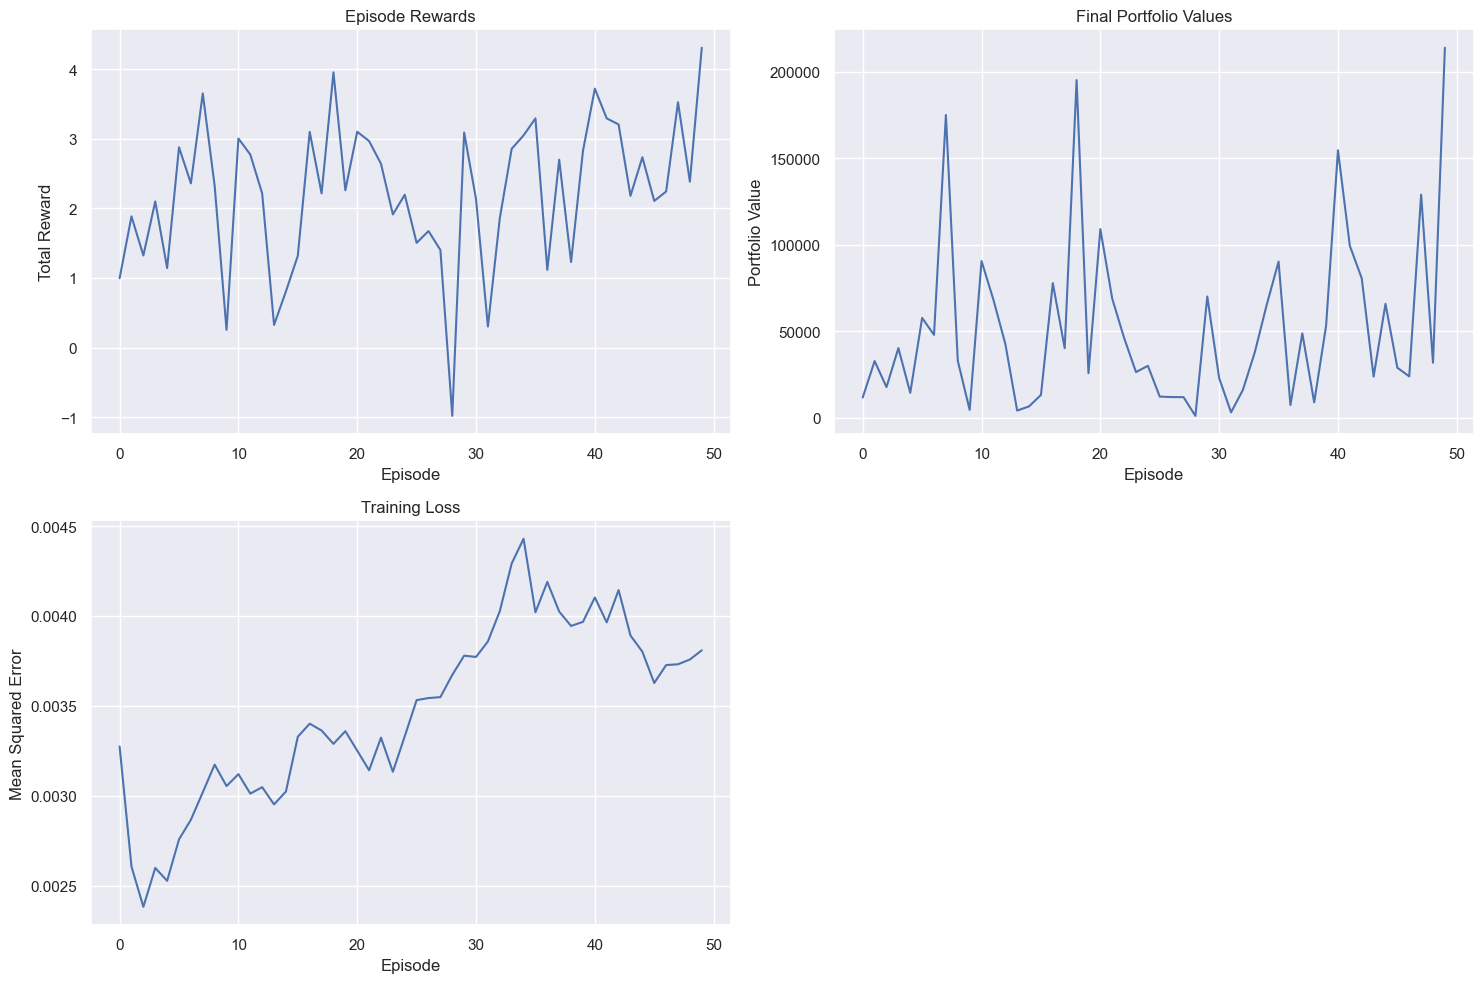

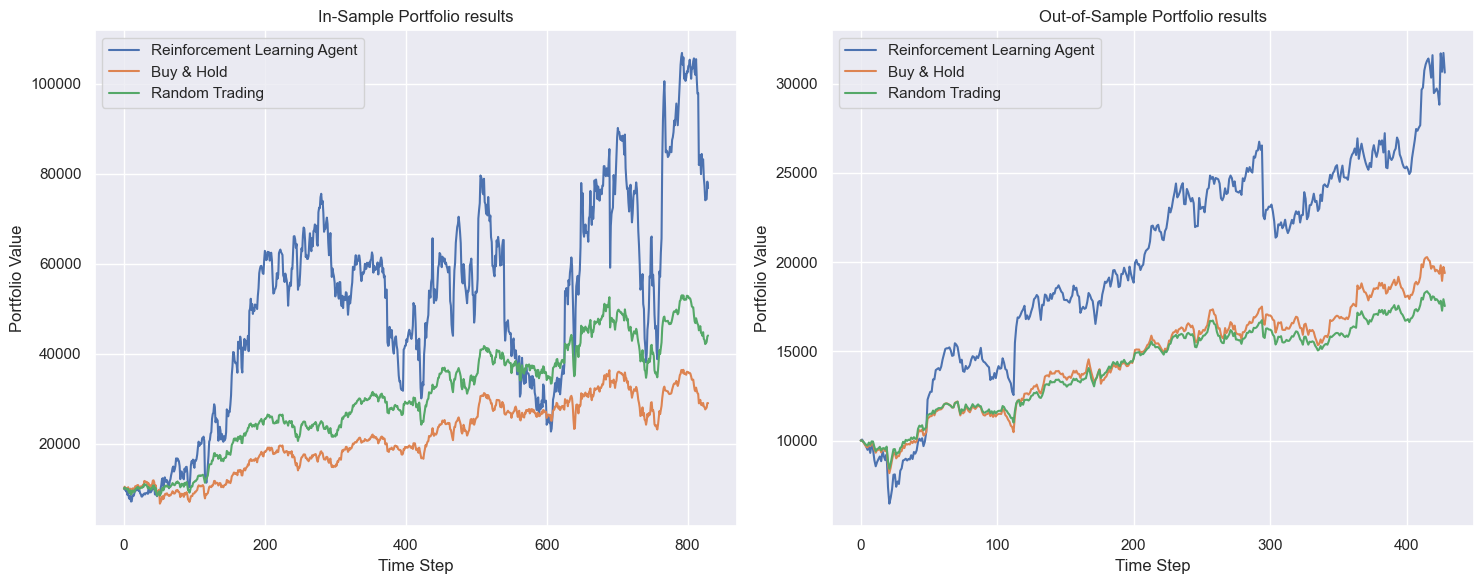

In [ ]:
def main():
    file_path = "YOUR_FILE_PATH.csv"
    #Load and normalize the data
    train_data_scaled, test_data_scaled= load_and_prepare_data(file_path)
    #Initialize the trading environments: test and train environments
    print("Initializing environments:")
    train_env = MyStockTradingEnv(train_data_scaled,initial_cash=10000)
    test_env = MyStockTradingEnv(test_data_scaled,initial_cash=10000)
    print(f"Training environment created. Data shape: {train_data_scaled.shape}")
    print(f"Testing environment created. Data shape: {test_data_scaled.shape}")
    state_dim = train_env.state_dim
    action_dim = train_env.action_space
    print(f"Initializing Q-network with state_dim={state_dim}, action_dim={action_dim}")
    #Initialize the Q-network with optimized hyperparameters
    q_network = LinearQNetwork(
            state_dim=state_dim, 
            action_dim=action_dim, 
            learning_rate=0.0001, 
            momentum=0.9, 
            lambda_reg=0.001  #L2 regularization factor
        )
    print("\n--- TRAINING AGENT ---")
    train_agent(
            train_env,
            q_network,
            episodes=50,
            gamma=0.9,     # Discount factor
            epsilon_start=1.0,
            epsilon_end=0.05,
            epsilon_decay=0.99,
            batch_size=32
        )

    print("\n--- EVALUATING ON TRAINING DATA ---")
    in_sample_portfolio_values, _, _ = evaluate_agent(train_env, q_network)
    print("\n--- EVALUATING ON TEST DATA ---")
    out_sample_portfolio_values, _, out_sample_trade_history = evaluate_agent(test_env, q_network)
    print("\n--- ANALYZING TRADING STRATEGY ---")
    analyze_trading_strategy(out_sample_trade_history, test_data_scaled)
    print("\n--- IMPLEMENTING BUY-AND-HOLD STRATEGY ---")
    buy_hold_train = buy_and_hold_strategy(train_data_scaled, initial_cash=10000)
    buy_hold_test = buy_and_hold_strategy(test_data_scaled, initial_cash=10000)
    print("\n--- IMPLEMENTING RANDOM TRADING STRATEGY ---")
    random_train = random_trading_strategy(deepcopy(train_env), episodes=50) #use deepcopy to avoid modifying the original env
    random_test = random_trading_strategy(deepcopy(test_env), episodes=50) #same here

    # Plot portfolio comparison
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(in_sample_portfolio_values, label='Reinforcement Learning Agent')
    plt.plot(buy_hold_train, label='Buy & Hold')
    plt.plot(random_train, label='Random Trading')
    plt.title('In-Sample Portfolio results')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(out_sample_portfolio_values, label='Reinforcement Learning Agent')
    plt.plot(buy_hold_test, label='Buy & Hold')
    plt.plot(random_test, label='Random Trading')
    plt.title('Out-of-Sample Portfolio results')
    plt.xlabel('Time Step')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.tight_layout()

    print("\n--- Summary Statistics ---")
    print(f"In-Sample Final Value (RL): {in_sample_portfolio_values[-1]:.2f}")
    print(f"In-Sample Final Value (Buy & Hold): {buy_hold_train[-1]:.2f}")
    print(f"In-Sample Final Value (Random): {random_train[-1]:.2f}")
    print(f"\nOut-of-Sample Final Value (RL): {out_sample_portfolio_values[-1]:.2f}")
    print(f"Out-of-Sample Final Value (Buy & Hold): {buy_hold_test[-1]:.2f}")
    print(f"Out-of-Sample Final Value (Random): {random_test[-1]:.2f}")

if __name__ == "__main__":
    main()

#### Interpretation of the 3 training graphs: 

The Episode Rewards chart (top left) shows significant volatility in the returns across training episodes, with rewards generally positive but experiencing occasional sharp drops (notably around episode 30). Despite fluctuations, there's an overall upward trend culminating in the highest reward in the final episode, suggesting the agent is improving over time.  

The Final Portfolio Values graph (top right) reveals extreme variability in performance outcomes, with some episodes achieving spectacular returns (exceeding $150,000) while others deliver more modest results. This high variance indicates the strategy involves substantial risk, possibly from concentrated positions or aggressive trading patterns.  

The Training Loss chart (bottom) shows a generally increasing mean squared error throughout training. This unusual pattern, where loss increases rather than decreases, might suggest the algorithm is exploring more complex strategies over time or potentially overfitting to noise in the market data. This rising error, combined with the high variance in portfolio values, indicates the model may be learning high-risk, high-reward behaviors that work extremely well in certain market conditions but could be vulnerable to significant drawdowns.

#### Interpretation of the portfolio values
Thanks to the graphs and logs printed during the evaluation of the models, we can say that the reinforcement learning algorithm demonstrates remarkable effectiveness in stock trading, significantly outperforming both buy-and-hold and random trading strategies across training and testing datasets. With a **668%** return in-sample and **206%** return out-of-sample. This RL algo is very efficient. We can also see that the random trading strategy outperforms the buy and hold which is weird and might be caused by the overall upward trend of the market. Indeed if someone holds stocks most of the time, they are more likely to benefit from this current bull market.

The algorithm's active trading approach is characterized by frequent buying and selling with minimal holding. We can say that the agent learned on this data to follow an active trading approach rather than a passive one (buy and hold). The agent learned to concentrate its assets on high performing assets, indeed during the training phase he chose to concentrate on MSI and on SBUX during the testing phase. The fact that the agent learned to maintain consistent outperformance in new market conditions suggests the model has learned generalizable trading patterns rather than merely overfitting to historical data. This impressive performance, achieved with reasonable drawdown levels, indicates that reinforcement learning can effectively capture complex market dynamics and translate them into profitable trading decisions.

In a further development of the model, we can think about adding transaction costs to the reinforcement learning model would deliver a more realistic assessment and likely transform its strategy. The current approach's frequent trading would generate significant costs in real markets, diminishing its apparent advantage. Incorporating these costs would incentivize the algorithm to trade more selectively, potentially adopting a more balanced approach that better reflects market performance.

## Comments

This coursework presented a significant challenge, as I hadn't do much of RL algo before. However, I found the project both engaging and rewarding, as it provided an opportunity to dive deeply into the subject and develop innovative solutions on my own.  

Throughout the project, I invested considerable time in researching and implementing various RL techniques. Some of the key contributions I made include the integration of a prioritized replay buffer, the application of L2 regularization, and the design of an effective reward function. 

One of the primary insights I gained is the critical importance of fine-tuning parameters such as the number of episodes, learning rate, and decay rate. These parameters can profoundly influence the behavior of the RL agent, and finding the optimal configuration is essential to achieve good performance.

During the development process, I encountered several challenges, particularly with overfitting to the in-sample data. Initially, the RL model learned patterns that resulted in extraordinarily high returns, often 10 to 100 times greater than the baseline. To mitigate this issue, I implemented L2 regularization to reduce overfitting and limited the number of training episodes. Additionally, I employed Q-targeting and normalized the data between 1 and 10 (instead of the typical 0 to 1 range) to control the number of shares the model could purchase, preventing it from crashing due to excessive share holdings.

In the end, I successfully developed an RL model that outperforms the baselines and I'm fairly happy of it.